In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os, sys
import esutil, scipy
sys.path.append('../')
from xd import *

from utils import *
from cmass_modules import io, Cuts
%matplotlib inline
%load_ext autoreload
%autoreload 2


import sys
sys.path.append('/n/des/lee.5922/programs/cosmolike/MG_musigma/cosmolike_planck_working/')
#from plot_chain import plot_single, plot_triple #, calling_public_planck_chains

#from chainconsumer import ChainConsumer


HF = lambda Nr,Nbin: (Nr-Nbin-2) *1./(Nr-1)
HFactor = HF(100, 10)

/home/lee.5922/.local/lib/python2.7/site-packages/matplotlib/__init__.py:1405: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [136]:
def loadfits_twopoint(fitsname, covmat_name="COVMAT"):
    
    import twopoint
    f = twopoint.TwoPointFile.from_fits(fitsname, covmat_name=covmat_name)
    
    xip = f.get_spectrum('xip').value
    xim = f.get_spectrum('xim').value
    gammat = f.get_spectrum('gammat').value
    wtheta = f.get_spectrum('wtheta').value
    galaxy_cmbkappa_xi = f.get_spectrum('galaxy_cmbkappa_xi').value
    shear_cmbkappa_xi = f.get_spectrum('shear_cmbkappa_xi').value

    angle = f.get_spectrum('galaxy_cmbkappa_xi').angle
    
    if covmat_name is None : 
        return [angle, galaxy_cmbkappa_xi]
    else : 
        covmat = f.covmat
        starts = f.covmat_info.starts
        covmat_galaxy_cmbkappa_xi = covmat[starts[4]:starts[5], starts[4]:starts[5]]
        return [angle, galaxy_cmbkappa_xi, covmat_galaxy_cmbkappa_xi]        

In [315]:
def chisquare(dv1, dv2, cov, rcond=1e-10):
    diff = dv1 - dv2
    F = np.linalg.pinv(cov, rcond=rcond)
    chi = np.dot( diff, np.dot( F, diff))
    print chi
    return chi

In [345]:
fitsname = '/n/des/lee.5922/programs/cosmolike/cosmosis/output_cmblensing_cmass/cmblensing_cmass_sgc_lrange8_2048_fwhm1p71.fits'
angle, xi_gk_sgc, cov_gk_sgc_analytic = loadfits_twopoint(fitsname)
err_gk_sgc = np.sqrt(cov_gk_sgc_analytic.diagonal())

fitsname = '/n/des/lee.5922/programs/cosmolike/cosmosis/output_cmblensing_cmass/cmblensing_cmass_ngc_lrange8_2048_fwhm1p71.fits'
angle, xi_gk_ngc, cov_gk_ngc_analytic = loadfits_twopoint(fitsname)
err_gk_ngc = np.sqrt(cov_gk_ngc_analytic.diagonal())

F_gk_sgc = np.linalg.pinv(cov_gk_sgc_analytic, rcond=1e-5)
F_gk_ngc = np.linalg.pinv(cov_gk_ngc_analytic, rcond=1e-5)
cov_gk_full_analytic = np.linalg.pinv( F_gk_sgc + F_gk_ngc , rcond=1e-5 )

fitsname = '/n/des/lee.5922/programs/cosmolike/cosmosis/output_cmblensing_cmass/cmblensing_dmass_lrange8_2048_fwhm1p71.fits'
angle, xi_gk_dmass, cov_gk_dmass_analytic = loadfits_twopoint(fitsname)
err_gk_dmass = np.sqrt(cov_gk_dmass_analytic.diagonal())


In [344]:
cov_gk_ngc_analytic.diagonal()

array([1.84897873e-07, 1.64494489e-07, 1.29686305e-07, 8.70476149e-08,
       6.06896131e-08, 4.38626254e-08, 3.03093692e-08, 1.99085358e-08,
       1.27052220e-08, 7.97049267e-09, 4.76333361e-09, 2.73449435e-09])

In [346]:
cov_gk_full_analytic.diagonal()

array([1.35938902e-07, 1.20926041e-07, 9.53149528e-08, 6.39464614e-08,
       4.45655482e-08, 3.22002622e-08, 2.22436894e-08, 1.46055181e-08,
       9.31803028e-09, 5.84436591e-09, 3.49224972e-09, 2.00467969e-09])

In [343]:
err_gk_ngc

array([4.29997527e-04, 4.05579202e-04, 3.60119849e-04, 2.95038328e-04,
       2.46352619e-04, 2.09434060e-04, 1.74095862e-04, 1.41097611e-04,
       1.12717443e-04, 8.92776157e-05, 6.90169082e-05, 5.22923929e-05])

In [208]:
fitsname = '/n/des/lee.5922/programs/cosmolike/cosmosis/output_cmblensing_cmass/cmblensing_cmass_ngc_lrange8_2048_fwhm1p71.fits'
angle_test, xi_gk_test, cov_gk_test = loadfits_twopoint(fitsname)
err_gk_test = np.sqrt(cov_gk_test.diagonal())

fitsname = '/n/des/lee.5922/programs/cosmolike/cosmosis/output_cmblensing_cmass/cmblensing_cmass_sgc_lrange8_2048_fwhm1p71.fits'
angle_test, xi_gk_sgc_test, cov_gk_sgc_test = loadfits_twopoint(fitsname)
err_gk_sgc_test = np.sqrt(cov_gk_sgc_test.diagonal())

fitsname = '/n/des/lee.5922/programs/cosmolike/cosmosis/output_cmblensing_cmass/cmblensing_dmass_lrange8_2048_fwhm1p71.fits'
angle_test, xi_gk_dmass_test, cov_gk_dmass_test = loadfits_twopoint(fitsname)
err_gk_dmass_test = np.sqrt(cov_gk_dmass_test.diagonal())


In [167]:
cmblensing_dir = '../output/cmblensing/'
HFactor158 = 1.0

rmin_cmb_dmass, kappa_cmb_dmass = np.genfromtxt(cmblensing_dir + 'w_dmass_x_cmblensing_systot.txt', unpack=True)
cov_cmb_dmass = np.genfromtxt(cmblensing_dir + 'w_dmass_x_cmblensing_systot.cov') * 1./HFactor158
err_cmb_dmass = np.sqrt( cov_cmb_dmass.diagonal() )

rmin_cmb_sgc, kappa_cmb_sgc = np.genfromtxt(cmblensing_dir + 'w_cmass_south_x_cmblensing.txt', unpack=True)
cov_cmb_sgc = np.genfromtxt(cmblensing_dir + 'w_cmass_south_x_cmblensing.cov')* 1./HFactor158
err_cmb_sgc = np.sqrt( cov_cmb_sgc.diagonal() )

rmin_cmb_ngc, kappa_cmb_ngc = np.genfromtxt(cmblensing_dir + 'w_cmass_north_x_cmblensing.txt', unpack=True)
cov_cmb_ngc = np.genfromtxt(cmblensing_dir + 'w_cmass_north_x_cmblensing.cov')* 1./HFactor158
err_cmb_ngc = np.sqrt( cov_cmb_ngc.diagonal() )

rmin_cmb_full, kappa_cmb_full, err_cmb_full = np.genfromtxt(cmblensing_dir + 'w_cmass_tot_x_cmblensing.txt', unpack=True)
cov_cmb_full = np.linalg.inv(np.linalg.inv(cov_cmb_sgc)+np.linalg.inv(cov_cmb_ngc))* 1./HFactor158
err_cmb_full = err_cmb_full * 1./np.sqrt(HFactor158)

#rmin_cmb_th, kappa_cmb_theory = np.genfromtxt(cmblensing_dir+'theory_cmass_tot_cmblensing_b2.txt', unpack=True)
rmin_cmb_th, kappa_cmb_theory = np.genfromtxt(cmblensing_dir+'re/cmassnorth_cmbkappa_galbias1p75.asc', unpack=True)
kappa_cmb_theory_interp = scipy.interpolate.interp1d(rmin_cmb_th, kappa_cmb_theory)
kappa_cmb_theory_interp = kappa_cmb_theory_interp(rmin_cmb_dmass)

rmin_cmb_dmass_re, kappa_cmb_dmass_re = np.genfromtxt(cmblensing_dir + 're/out_DMASS_nosysweight_mean.out', unpack=True)
cov_cmb_dmass_re = np.genfromtxt(cmblensing_dir + 're/out_DMASS_nosysweight.cov') * 1./HFactor158
err_cmb_dmass_re = np.sqrt( cov_cmb_dmass_re.diagonal() )

rmin_cmb_dmass_re_sys, kappa_cmb_dmass_re_sys = np.genfromtxt(cmblensing_dir + 're/out_DMASS_withsysweight_mean.out', unpack=True)
cov_cmb_dmass_re_sys = np.genfromtxt(cmblensing_dir + 're/out_DMASS_withsysweight.cov') * 1./HFactor158
err_cmb_dmass_re_sys = np.sqrt( cov_cmb_dmass_re_sys.diagonal() )

In [348]:
print'jk cov:' 
chi_gk_DS = chisquare(kappa_cmb_dmass, kappa_cmb_sgc, cov_cmb_dmass + cov_cmb_sgc)
chi_gk_DF = chisquare(kappa_cmb_dmass, kappa_cmb_full, cov_cmb_dmass + cov_cmb_full)
#print chi_gk_DS, chi_gk_DF

print '\nanalytic:'
chi_gk_DS = chisquare(kappa_cmb_dmass_re_sys, kappa_cmb_sgc, cov_gk_dmass_analytic + cov_gk_sgc_analytic, rcond=1e-5)
chi_gk_DF = chisquare(kappa_cmb_dmass_re_sys, kappa_cmb_ngc, cov_gk_dmass_analytic + cov_gk_ngc_analytic, rcond=1e-5)
chi_gk_DF = chisquare(kappa_cmb_dmass_re_sys, kappa_cmb_full, cov_gk_dmass_analytic + cov_gk_full_analytic, rcond=1e-5)

#chi_gk_D = chisquare(kappa_cmb_dmass, xi_gk_dmass_test, cov_gk_dmass_test)
#chi_gk_S = chisquare(kappa_cmb_sgc, xi_gk_sgc_test, cov_gk_sgc_test)
#print chi_gk_DS, chi_gk_DF

jk cov:
4.3234025665913896
6.389234582876061

analytic:
12.561062284315241
50.16509495821554
30.630612002011976


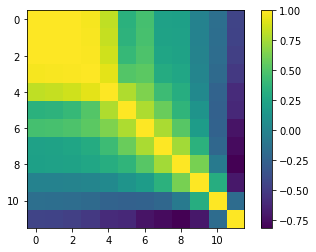

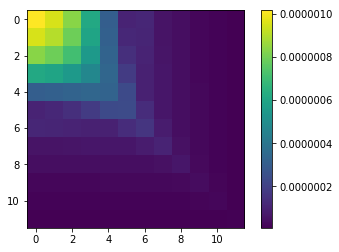

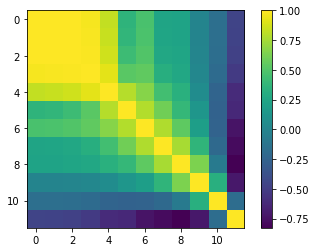

In [312]:
fig, ax = plt.subplots()
#ax.imshow( np.linalg.inv(cov_gk_dmass_test))
im = ax.imshow( np.corrcoef(cov_gk_dmass_test) )
fig.colorbar(im, ax=ax)

fig, ax = plt.subplots()
#ax.imshow( np.linalg.inv(cov_gk_dmass_test))
im = ax.imshow( cov_gk_dmass_test) 
fig.colorbar(im, ax=ax)

fig, ax = plt.subplots()
#ax.imshow( np.linalg.inv(cov_gk_dmass_test))
im = ax.imshow( np.corrcoef(cov_gk_test) )
fig.colorbar(im, ax=ax)

In [227]:
help(np.linalg.pinv)

Help on function pinv in module numpy.linalg:

pinv(a, rcond=1e-15)
    Compute the (Moore-Penrose) pseudo-inverse of a matrix.
    
    Calculate the generalized inverse of a matrix using its
    singular-value decomposition (SVD) and including all
    *large* singular values.
    
    .. versionchanged:: 1.14
       Can now operate on stacks of matrices
    
    Parameters
    ----------
    a : (..., M, N) array_like
        Matrix or stack of matrices to be pseudo-inverted.
    rcond : (...) array_like of float
        Cutoff for small singular values.
        Singular values smaller (in modulus) than
        `rcond` * largest_singular_value (again, in modulus)
        are set to zero. Broadcasts against the stack of matrices
    
    Returns
    -------
    B : (..., N, M) ndarray
        The pseudo-inverse of `a`. If `a` is a `matrix` instance, then so
        is `B`.
    
    Raises
    ------
    LinAlgError
        If the SVD computation does not converge.
    
    Notes
    -

In [277]:
F_gk_dmass_test = np.linalg.pinv(cov_gk_dmass_test, rcond=1e-5)
F_gk_sgc_test = np.linalg.pinv(cov_gk_sgc_test, rcond=1e-05)

cov_gk_dmass_test_re = np.linalg.pinv(F_gk_dmass_test, rcond=1e-5)
cov_gk_sgc_test_re = np.linalg.pinv(F_gk_sgc_test, rcond=1e-5)

cov_gk_DS_test = cov_gk_dmass_test + cov_gk_sgc_test
F_gk_DS_test = np.linalg.pinv( cov_gk_DS_test , rcond=1e-5)
cov_gk_DS_test_re = np.linalg.pinv(F_gk_DS_test , rcond=1e-5)

In [250]:
cov_gk_dmass_test.diagonal()

array([1.01642024e-06, 9.03281245e-07, 7.10354921e-07, 4.74354823e-07,
       3.29283504e-07, 2.37238879e-07, 1.63345127e-07, 1.06840818e-07,
       6.79102485e-08, 4.24745529e-08, 2.53237481e-08, 1.45143426e-08])

In [251]:
np.linalg.pinv(F_gk_dmass_test, rcond=1e-15).diagonal()

array([1.01642033e-06, 9.03280077e-07, 7.10355140e-07, 4.74354683e-07,
       3.29283542e-07, 2.37238898e-07, 1.63345126e-07, 1.06840820e-07,
       6.79102487e-08, 4.24745530e-08, 2.53237481e-08, 1.45143426e-08])

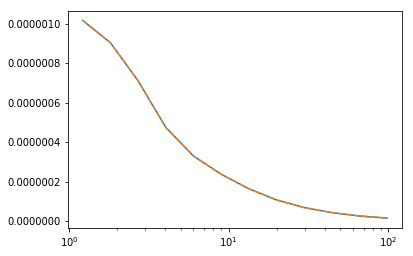

In [281]:
fig, ax = plt.subplots()
ax.plot( angle_test, cov_gk_dmass_test.diagonal() , '-')
ax.plot( angle_test, cov_gk_dmass_test_re.diagonal() , '--')

#ax.plot( angle_test, cov_gk_DS_test.diagonal(), '-' )
#ax.plot( angle_test, cov_gk_DS_test_re.diagonal(), '--' )

ax.set_xscale('log')

In [282]:
print '\ndata:'
#print np.sum((kappa_cmb_dmass - xi_gk_dmass_test)**2 * 1./cov_gk_dmass_test.diagonal())
diffv = kappa_cmb_dmass - kappa_cmb_sgc
print np.dot(np.dot( diffv,  F_gk_DS_test ), diffv.T)


data:
13.85615872922409


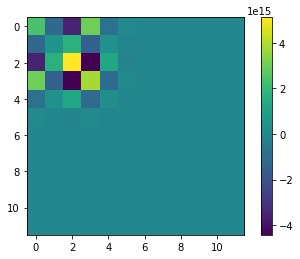

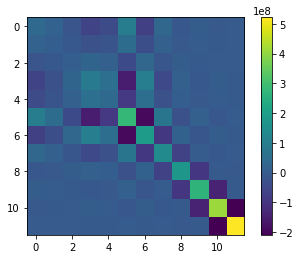

In [252]:
fig, ax = plt.subplots()
#ax.imshow( np.linalg.inv(cov_gk_dmass_test))
im = ax.imshow( F_gk_dmass_test )
fig.colorbar(im, ax=ax)

fig, ax = plt.subplots()
#ax.imshow( np.linalg.inv(cov_gk_dmass_test))
im = ax.imshow( F_gk_test )
fig.colorbar(im, ax=ax)

In [44]:
np.logspace( np.log10(1), np.log10(120), 13 )

array([  1.        ,   1.4902705 ,   2.22090615,   3.30975092,
         4.93242415,   7.35064619,  10.95445115,  16.32509536,
        24.32880798,  36.25650477,  54.03199939,  80.52229459,
       120.        ])

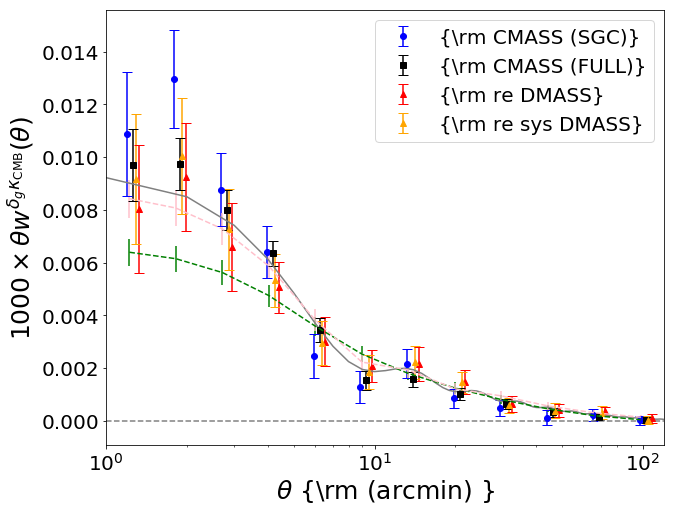

In [171]:
fig, ax = plt.subplots(figsize = (10,8))

ax.errorbar( rmin_cmb_sgc*0.95, kappa_cmb_sgc, yerr = err_cmb_sgc, fmt='o',color = 'b',  capsize=5, label=r'{\rm CMASS (SGC)}' )
ax.errorbar( rmin_cmb_full*1., kappa_cmb_full, yerr = err_cmb_full, fmt = 's', color = 'k', capsize=5, label=r'{\rm CMASS (FULL)}' )
#ax.errorbar( rmin_cmb_dmass*1.05, 1000*rmin_cmb_dmass*kappa_cmb_dmass, yerr = 1000*rmin_cmb_dmass*err_cmb_dmass, fmt='^', color = 'r', capsize=5, label=r'{\rm DMASS}' )

ax.errorbar( rmin_cmb_dmass_re*1.05, kappa_cmb_dmass_re, \
            yerr = err_cmb_dmass_re, fmt='^', color = 'r', capsize=5, label=r'{\rm re DMASS}' )
ax.errorbar( rmin_cmb_dmass_re_sys*1.02, kappa_cmb_dmass_re_sys,\
            yerr = err_cmb_dmass_re_sys, fmt='^', color = 'orange', capsize=5, label=r'{\rm re sys DMASS}' )


ax.plot(rmin_cmb_th, kappa_cmb_theory, '-', color='grey')
ax.axhline(y=0, ls='--', color='grey')
ax.set_xscale('log')
#ax.set_yscale('log')


err_galaxy_cmbkappa_xi = np.sqrt(covmat_galaxy_cmbkappa_xi.diagonal())
ax.errorbar(angle, xi_gk_sgc, fmt='--', yerr = err_gk_sgc, color='green')
ax.errorbar(angle_test, xi_gk_test, fmt='--', yerr = err_gk_sgc_test, color='pink')
#ax.errorbar(angle, xi_gk_ngc, fmt='-', yerr = err_gk_ngc, color='k')
#ax.errorbar(angle, xi_gk_dmass, fmt='-', yerr = err_gk_dmass, color='r')



ax.legend(loc = 1, fontsize = 20)
ax.set_xlim(1, 120)
#ax.set_ylim(-20,60)
ax.set_ylabel(r'$1000 \times \theta w^{\delta_{g} \kappa_{\rm CMB}} (\theta) $', fontsize = 25)
ax.set_xlabel(r'$\theta$ {\rm (arcmin) }', fontsize = 25)
ax.tick_params(labelsize = 20)

#ax.text(1.3, -8, r'$\chi^2/$ $\rm dof ~(CMASS~SGC) $ $= {:0.2f}/{}$'.format(chi_ds, 10), fontsize = 20)
#ax.text(1.3, -13  , r'$\chi^2/$ $\rm dof ~(CMASS~FULL) $ $= {:0.2f}/{}$'.format(chi_df, 10), fontsize = 20)

#fig.savefig('../paper_figure//kappa_cmblensing_v2.pdf' )

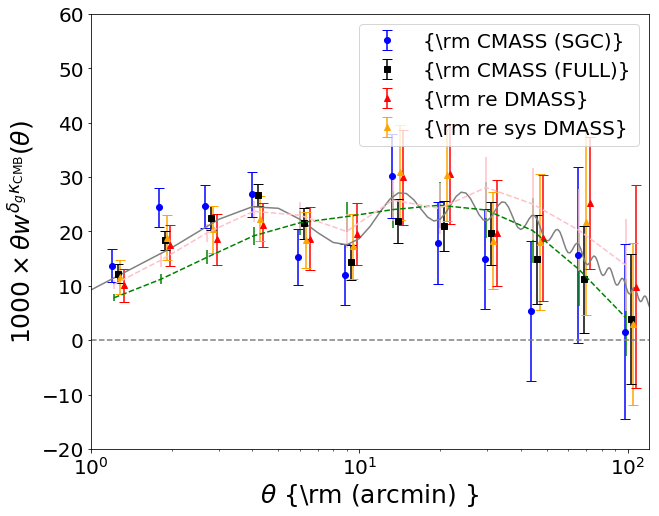

In [179]:
fig, ax = plt.subplots(figsize = (10,8))

ax.errorbar( rmin_cmb_sgc*0.95, 1000*rmin_cmb_sgc*kappa_cmb_sgc, yerr = 1000*rmin_cmb_sgc*err_cmb_sgc, fmt='o',color = 'b',  capsize=5, label=r'{\rm CMASS (SGC)}' )
ax.errorbar( rmin_cmb_full*1., 1000*rmin_cmb_full*kappa_cmb_full, yerr = 1000*rmin_cmb_full*err_cmb_full, fmt = 's', color = 'k', capsize=5, label=r'{\rm CMASS (FULL)}' )
#ax.errorbar( rmin_cmb_dmass*1.05, 1000*rmin_cmb_dmass*kappa_cmb_dmass, yerr = 1000*rmin_cmb_dmass*err_cmb_dmass, fmt='^', color = 'r', capsize=5, label=r'{\rm DMASS}' )

ax.errorbar( rmin_cmb_dmass_re*1.05, 1000*rmin_cmb_dmass_re*kappa_cmb_dmass_re, \
            yerr = 1000*rmin_cmb_dmass_re*err_cmb_dmass_re, fmt='^', color = 'r', capsize=5, label=r'{\rm re DMASS}' )
ax.errorbar( rmin_cmb_dmass_re_sys*1.02, 1000*rmin_cmb_dmass_re_sys*kappa_cmb_dmass_re_sys,\
            yerr = 1000*rmin_cmb_dmass_re_sys*err_cmb_dmass_re_sys, fmt='^', color = 'orange', capsize=5, label=r'{\rm re sys DMASS}' )


ax.plot(rmin_cmb_th, 1000*rmin_cmb_th*kappa_cmb_theory, '-', color='grey')
ax.axhline(y=0, ls='--', color='grey')
ax.set_xscale('log')
#ax.set_yscale('log')


err_galaxy_cmbkappa_xi = np.sqrt(covmat_galaxy_cmbkappa_xi.diagonal())
ax.errorbar(angle, 1000*angle*xi_gk_sgc, fmt='--', yerr = 1000*angle*err_gk_sgc, color='green')
ax.errorbar(angle_test, 1000*angle_test*xi_gk_test, fmt='--', yerr = 1000*angle_test*err_gk_sgc_test, color='pink')
#ax.errorbar(angle, 1000*angle*xi_gk_ngc, fmt='-', yerr = 1000*angle*err_gk_ngc, color='k')
#ax.errorbar(angle, 1000*angle*xi_gk_dmass, fmt='-', yerr = 1000*angle*err_gk_dmass, color='r')



ax.legend(loc = 1, fontsize = 20)
ax.set_xlim(1, 120)
ax.set_ylim(-20,60)
ax.set_ylabel(r'$1000 \times \theta w^{\delta_{g} \kappa_{\rm CMB}} (\theta) $', fontsize = 25)
ax.set_xlabel(r'$\theta$ {\rm (arcmin) }', fontsize = 25)
ax.tick_params(labelsize = 20)

#ax.text(1.3, -8, r'$\chi^2/$ $\rm dof ~(CMASS~SGC) $ $= {:0.2f}/{}$'.format(chi_ds, 10), fontsize = 20)
#ax.text(1.3, -13  , r'$\chi^2/$ $\rm dof ~(CMASS~FULL) $ $= {:0.2f}/{}$'.format(chi_df, 10), fontsize = 20)

#fig.savefig('../paper_figure//kappa_cmblensing_v2.pdf' )

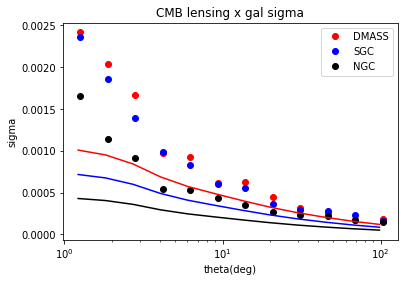

In [349]:
fig, ax = plt.subplots()
ax.plot(rmin_cmb_dmass_re, err_cmb_dmass_re, 'ro', label='DMASS')
ax.plot(rmin_cmb_dmass, err_cmb_sgc, 'bo', label='SGC')
ax.plot(rmin_cmb_dmass, err_cmb_ngc, 'ko', label='NGC')

ax.plot(angle, err_gk_sgc, 'b')
ax.plot(angle, err_gk_ngc, 'k')
ax.plot(angle, err_gk_dmass, 'r')

#ax.plot(angle_test, err_gk_sgc_test, 'b--')
#ax.plot(angle_test, err_gk_test, 'k--')
#ax.plot(angle_test, err_gk_dmass_test, 'r--')

ax.set_xscale('log')
ax.set_title('CMB lensing x gal sigma')
ax.set_xlabel('theta(deg)')
ax.set_ylabel('sigma')
ax.legend()